<style>
body {
    font-size: 20pt !important;
}

.rendered_html {
    font-size: 20pt !important;
}

.CodeMirror pre {
    font-size: 20pt !important;
}

.output pre {
    font-size: 20pt !important;
}
</style>


<h2 style="font-size:24pt"> Proyecto DESI</h2>

<h2 style="font-size:24pt"> Julio 9, 2025</h2>

<p style="font-size:16pt">
Calculation of the entropy and visualization of the normalized Shannon Entropy

In [26]:
import numpy as np
import matplotlib.tri as mtri
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii
import pandas as pd
import networkx as nx
import scipy
import seaborn as sns
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA
import random
from astropy.cosmology import Planck18
from astropy.coordinates import SkyCoord
from astropy import units as u
from functools import reduce

## Data

In [27]:
#Data
rosettes = list(range(20))
data = {}

for i, number_rosette in enumerate(rosettes):
    file = f"data_rosette/LRG_{number_rosette}_clustering_data.ecsv"
    table = Table.read(file, format="ascii.ecsv") 
    subset = table[['TARGETID','RA', 'DEC', 'Z','x','y','z']].to_pandas()
    data[f"data_{i}"] = subset

In [28]:
list_rand = list(range(18))
rand_tables_n = {}

for i in list_rand:
    url = f"https://data.desi.lbl.gov/public/edr/vac/edr/lss/v2.0/LSScats/clustering/LRG_N_{i}_clustering.ran.fits"
    rand_tables_n[f"rand_{i}_n"] = Table.read(url)

In [29]:
rand_tables_s = {}

for i in list_rand:
    url = f"https://data.desi.lbl.gov/public/edr/vac/edr/lss/v2.0/LSScats/clustering/LRG_S_{i}_clustering.ran.fits"
    rand_tables_s[f"rand_{i}_s"] = Table.read(url)

In [30]:
def cartesianas(data):
    data['distance'] = Planck18.comoving_distance(data['Z'])
    coords = SkyCoord(ra=data['RA'], dec=data['DEC'], distance=data['distance'], frame='icrs')
    data['x'] = coords.cartesian.x.value
    data['y'] = coords.cartesian.y.value
    data['z'] = coords.cartesian.z.value

    data['x'] = data['x'] * u.Mpc
    data['y'] = data['y'] * u.Mpc
    data['z'] = data['z'] * u.Mpc

In [31]:
def data_random(number_rosette,data):

    rosette_n = {3, 6, 7, 11, 12, 13, 14, 15, 18, 19}
    rosette_s = {0, 1, 2, 4, 5, 8, 9, 10, 16, 17}

    if number_rosette in rosette_n:
        orientation = 'n'
    elif number_rosette in rosette_s:
        orientation = 's'

    if orientation == 'n':
        keys = rand_tables_n
    elif orientation == 's':
        keys = rand_tables_s
    
    #Choose random table
    clave_aleatoria = random.choice(list(keys.keys()))
    rand_table = keys[clave_aleatoria]

    #Filter of the rosette in random
    rand_table_rosette = rand_table[rand_table['ROSETTE_NUMBER']==number_rosette]
        
    #Choose random index of the random table according to the len of rosette table
    len_rosette = len(data)
    idx_random = np.random.choice(len(rand_table_rosette), size=len_rosette, replace=False)
    rand_subset = rand_table_rosette[idx_random]

    #Add columns of the other coordinates
    cartesianas(rand_subset)
    
    return(rand_subset)

## 100 Random

In [74]:
number_random = 100
random_100 = {}
for i in range(20): 
    for j in range(number_random): 
        key = f'rosette{i}_rand{j}'
        random_100[key] = data_random(i, data[f"data_{i}"]).to_pandas()

## Concatenation

In [75]:
for name, table in data.items():
    table['type'] = 'data'

for name, table in random_100.items():
    table['type'] = 'rand'

In [76]:
data_all = {}

for key_data in data:
    for key_rand in random_100:
        if key_rand.startswith(key_data.replace('data_', 'rosette')):
            data_all[key_rand] = pd.concat(
                [data[key_data], random_100[key_rand]], ignore_index=True
            )

## Parameter r

In [77]:
def parameter_r(data_all):
    df_tri = data_all[['x', 'y', 'z']]
    tri = Delaunay(df_tri)
    
    G = nx.Graph()
    for i, row in df_tri.iterrows():
        G.add_node(i, pos=(row['x'], row['y'], row['z']))
    
    #Simplices: Indices of the points forming the simplices in the triangulation.
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 4): 
                G.add_edge(simplex[i], simplex[j]) #Add the connections between the nodes.
    
    #Label de points according to the type of data
    for i, tipo in enumerate(data_all['type']):
        G.nodes[i]['type'] = tipo

    #Add column with the degree of the network
    connections = dict(G.degree())

    for index, row in data_all.iterrows():
        connection = connections[index]
        data_all.loc[index, 'degree'] = connection

    #Add columns with the count of each type of connection (whether it is real or not).
    n_data = []
    n_random = []
    
    for i in G.nodes:
        real = 0
        random = 0
        for neighbor in G.neighbors(i):
            tipo = G.nodes[neighbor]['type']
            if tipo == 'data':
                real += 1
            elif tipo == 'rand':
                random += 1
        
        n_data.append(real)
        n_random.append(random)
    
    data_all['N_data'] = n_data
    data_all['N_random'] = n_random

    #Definition of r
    data_all['r'] = (data_all['N_data']-data_all['N_random'])/(data_all['N_data']+data_all['N_random'])

In [78]:
for rosette, table in data_all.items():
    parameter_r(table)

## Classification r

In [79]:
def classification(data):
    data['classification'] = 'unclassified'

    data.loc[(data['r'] >= -1.0) & (data['r'] <= -0.9), 'classification'] = 'void'
    data.loc[(data['r'] >  -0.9) & (data['r'] <=  0.0), 'classification'] = 'sheet'
    data.loc[(data['r'] >   0.0) & (data['r'] <=  0.9), 'classification'] = 'filament'
    data.loc[(data['r'] >   0.9) & (data['r'] <=  1.0), 'classification'] = 'knot'

    data.sort_values('z', inplace=True)

In [80]:
for rosette, table in data_all.items():
    classification(table)

## Entropy

In [82]:
#Rename the classification column to merge
for i in range(number_random):
    for rosette in range(20):
        key = f'rosette{rosette}_rand{i}'
        data_all[key] = data_all[key].rename(columns={'classification': f'class_{i}'})

In [83]:
#Merge with ID only the real data.
id_merged = {}
for rosette in range(20):
    df_rosette = []
    for i in range(number_random):
        key = f'rosette_{rosette}'
        key_random = f'rosette{rosette}_rand{i}'
        df = data_all[key_random][['TARGETID', f'class_{i}']]
        df_rosette.append(df)  
    if df_rosette:
        merged = reduce(lambda left, right: pd.merge(left, right, on='TARGETID', how='outer'), df_rosette)
        cols_class = [f'class_{j}' for j in range(number_random)]
        merged = merged.dropna(subset=cols_class)

        id_merged[key] = merged

In [84]:
def entropy(data):
    count = data[data.columns].apply(lambda row: row.value_counts(), axis=1)
    probabilidades = count.div(number_random)
    sum_entropy = probabilidades.apply(lambda row: np.sum(row[row > 0] * np.log2(row[row > 0])), axis=1)
    entropy = -(1/np.log2(4))*sum_entropy
    entropy = np.abs(entropy)
    return entropy,probabilidades

for i in range(20):
    key = f'rosette_{i}'
    df = id_merged[key]
    
    reset = entropy(df.set_index('TARGETID'))
    reset_entropy = reset[0].rename('entropy').reset_index()
    id_merged[key] = df.merge(reset_entropy, on='TARGETID', how='left')

## Normalized Shannon Entropy

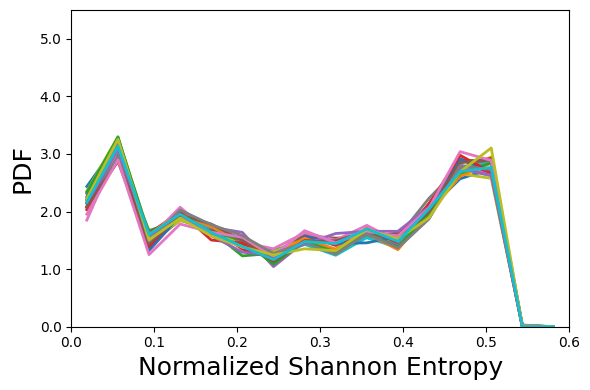

In [85]:
fig, ax = plt.subplots(figsize=(6, 4))

bins = 16
    
for i in range(20):
    key = f'rosette_{i}'
    entropy_values = id_merged[key]['entropy']
    hist, bin_edges = np.histogram(entropy_values, bins=bins, range=(0, 0.6), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
    ax.plot(bin_centers, hist, linewidth=2)
    
ax.set_xlabel(r"Normalized Shannon Entropy", fontsize=18)
ax.set_ylabel("PDF", fontsize=18)
ax.set_xlim(0, 0.6)
plt.ylim([0, 5.5])
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
plt.tight_layout()

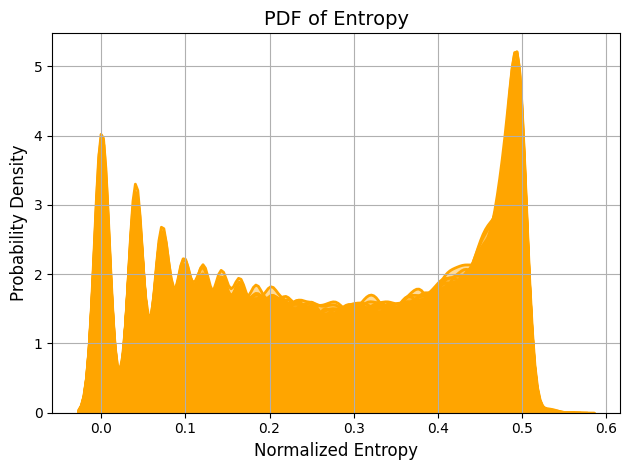

In [86]:
for i in range(20):
    key = f'rosette_{i}'
    entropy_values = id_merged[key]['entropy']
    sns.kdeplot(entropy_values, fill=True, bw_adjust=0.3, color='orange', linewidth=2, alpha=0.4)

# Etiquetas y estética
plt.xlabel('Normalized Entropy', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('PDF of Entropy', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()